<a href="https://colab.research.google.com/github/Ahsiiiiiii/Ahsan/blob/master/AhsanLTC_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow-gpu==2.0.0-alpha0

    100% |████████████████████████████████| 332.1MB 51kB/s 
    100% |████████████████████████████████| 61kB 19.3MB/s 
    100% |████████████████████████████████| 419kB 11.5MB/s 
    100% |████████████████████████████████| 3.0MB 5.7MB/s 


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

In [ ]:
# Data comes from:
# https://finance.yahoo.com/quote/BTC-USD/history?period1=1279314000&period2=1556053200&interval=1d&filter=history&frequency=1d

csv_path = "https://raw.githubusercontent.com/Ahsiiiiiii/LTC/main/LTC-USD.csv"
# csv_path = "https://raw.githubusercontent.com/curiousily/Deep-Learning-For-Hackers/master/data/3.stock-prediction/AAPL.csv"

In [ ]:
df = pd.read_csv(csv_path, parse_dates=['Date'])

In [ ]:
df = df.sort_values('Date')

In [ ]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-07-25,0.115203,0.115841,0.101531,0.105870,0.105870,145269.0
1,2017-07-26,0.105893,0.109013,0.099266,0.105138,0.105138,200395.0
2,2017-07-27,0.105108,0.108479,0.100888,0.107737,0.107737,344499.0
3,2017-07-28,0.107632,0.109019,0.101473,0.104067,0.104067,342568.0
4,2017-07-29,0.104782,0.111264,0.101108,0.107811,0.107811,340218.0


In [ ]:
df.shape

(1424, 7)

Text(0, 0.5, 'Close Price (USD)')

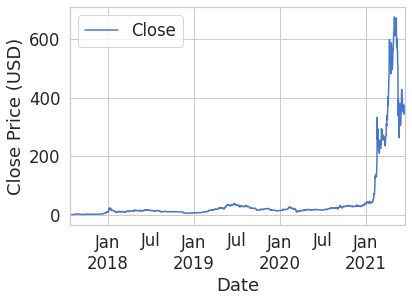

In [ ]:
ax = df.plot(x='Date', y='Close');
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (USD)")

# Normalization

In [ ]:
scaler = MinMaxScaler()

close_price = df.Close.values.reshape(-1, 1)

scaled_close = scaler.fit_transform(close_price)

In [ ]:
scaled_close.shape

(1424, 1)

In [ ]:
np.isnan(scaled_close).any()

True

In [ ]:
scaled_close = scaled_close[~np.isnan(scaled_close)]

In [ ]:
scaled_close = scaled_close.reshape(-1, 1)

In [ ]:
np.isnan(scaled_close).any()

False

# Preprocessing

In [ ]:
SEQ_LEN = 100

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.80)

In [ ]:
X_train.shape

(1055, 99, 1)

In [ ]:
X_test.shape

(264, 99, 1)

# Model

In [ ]:
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1

model = keras.Sequential()

model.add(Bidirectional(CuDNNLSTM(WINDOW_SIZE, return_sequences=True),
                        input_shape=(WINDOW_SIZE, X_train.shape[-1])))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(CuDNNLSTM((WINDOW_SIZE * 2), return_sequences=True)))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(CuDNNLSTM(WINDOW_SIZE, return_sequences=False)))

model.add(Dense(units=1))

model.add(Activation('linear'))

# Training

In [ ]:
model.compile(
    loss='mean_squared_error', 
    optimizer='adam'
)

In [ ]:
BATCH_SIZE = 64

history = model.fit(
    X_train, 
    y_train, 
    epochs=200, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    validation_split=0.1
)

Epoch 1/200
15/15 [==============================] - 4s 110ms/step - loss: 6.6677e-04 - val_loss: 3.1883e-04
Epoch 2/200
15/15 [==============================] - 1s 46ms/step - loss: 1.7567e-04 - val_loss: 3.8571e-05
Epoch 3/200
15/15 [==============================] - 1s 46ms/step - loss: 2.3192e-04 - val_loss: 5.9637e-05
Epoch 4/200
15/15 [==============================] - 1s 46ms/step - loss: 1.7545e-04 - val_loss: 2.8650e-04
Epoch 5/200
15/15 [==============================] - 1s 46ms/step - loss: 1.8191e-04 - val_loss: 4.7343e-05
Epoch 6/200
15/15 [==============================] - 1s 46ms/step - loss: 1.9844e-04 - val_loss: 6.2899e-05
Epoch 7/200
15/15 [==============================] - 1s 46ms/step - loss: 1.8391e-04 - val_loss: 5.3762e-05
Epoch 8/200
15/15 [==============================] - 1s 45ms/step - loss: 1.9823e-04 - val_loss: 2.4653e-05
Epoch 9/200
15/15 [==============================] - 1s 45ms/step - loss: 2.1951e-04 - val_loss: 2.6020e-05
Epoch 10/200
15/15 [=======

In [ ]:
model.evaluate(X_test, y_test)

9/9 [==============================] - 0s 33ms/step - loss: 0.0032


0.0031834545079618692

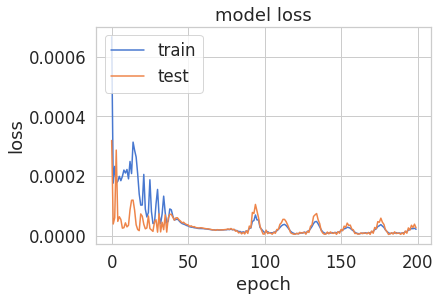

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Prediction

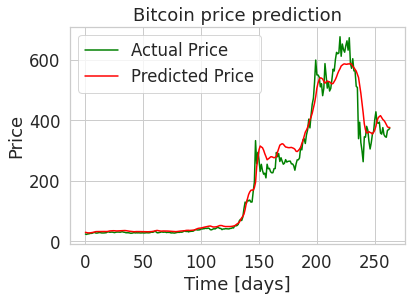

In [ ]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
 
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('Bitcoin price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show();